# Comparison of Regridding, Spatial Interpolation or Resampling Routines in Basemap, xESMF, xArray, PyInterp, SciPy and CartoPy

In [1]:
#Importing Libraries

import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap, interp
from osgeo import gdal
import pyinterp
import pyinterp.backends.xarray as pbx
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import interpolate
from scipy.interpolate import interp2d
import time


Bad key "text.kerning_factor" on line 4 in
/home/splash/anaconda3/envs/om/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Basemap

0.09941206599999997


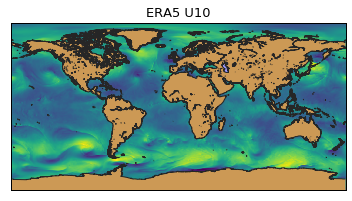

In [2]:
filename = '/home/splash/era5_data/u10m/era5_2020_3_21_u10m.nc'
with Dataset(filename, mode='r') as fh:
    lon = fh.variables['longitude'][:]
    lat = fh.variables['latitude'][:]
    u10 = fh.variables['u10'][0,:,:]
    
# take care of lon issue
fltr = lon >= 180
lonNew = np.concatenate(((lon - 360)[fltr], lon[~fltr]))

# now do the same for u10 (on X axis) but also invert Y axis with [::-1]
u10new = np.concatenate((u10[:, fltr], u10[:, ~fltr]), axis=-1)[::-1]

# now invert the remaining lat axis with [::-1]
latNew = lat[::-1]

lons_sub, lats_sub = np.meshgrid(np.arange(-180, 180.25, 0.25),
                     np.arange(-90, 90.25, 0.25))

t = time.process_time() #Starting Timer

#How Basemap handles the problem
coarse = interp(datain=u10new, xin=lonNew, yin=latNew, xout=lons_sub, yout=lats_sub, order=1)

elapsed_time = time.process_time() - t #Ending Timer
print(elapsed_time) #Printing Time

m = Basemap(projection='cyl',llcrnrlat=latNew[0],llcrnrlon=lonNew[0],urcrnrlat=latNew[-1],urcrnrlon=lonNew[-1],resolution='i')

#Plotting (can be made as fancy or as simple as we like)
x, y = m(lons_sub, lats_sub)
m.drawmapboundary(fill_color='#9999FF')
m.fillcontinents(color='#cc9955', lake_color='#9999FF', zorder = 1)
m.drawcoastlines(color = '0.15')
plt.title('ERA5 U10', fontsize=13)
data = m.pcolormesh(x,y,u10new)
plt.show(data)

# xESMF

Overwrite existing file: bilinear_641x1440_721x1441.nc 
 You can set reuse_weights=True to save computing time.
23.513185829999998


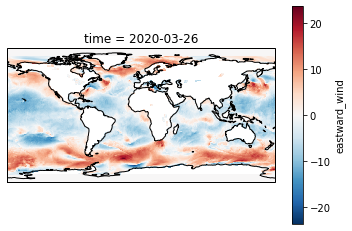

In [5]:
ds = xr.open_dataset('/home/splash/cmems_data/ew/cmems_2020_3_26_ew.nc')
dr = ds['eastward_wind']

#ax = plt.axes(projection=ccrs.PlateCarree())
#dr.isel(time=0).plot.pcolormesh(ax=ax);
#ax.coastlines();

ds['lat'].values, ds['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90.25, 0.25)),
                     'lon': (['lon'], np.arange(-180, 180.25, 0.25)),
                    }
                   )
t = time.process_time() #Starting Timer

#How xESMF handles the problem
regridder = xe.Regridder(ds, ds_out, 'bilinear')

elapsed_time = time.process_time() - t #Ending Timer
print(elapsed_time) #Printing Time

dr_out = regridder(dr)

ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax);
ax.coastlines();

# xArray

0.14141176700000102


Text(0.5, 1.0, 'Interpolated data')

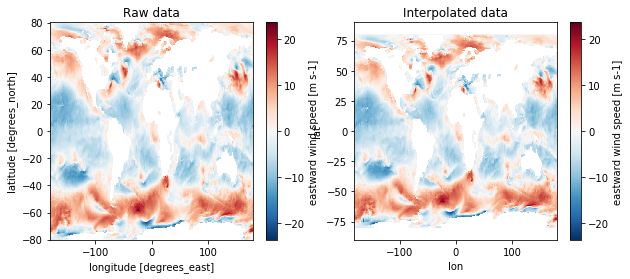

In [4]:
ds = xr.open_dataset('/home/splash/cmems_data/ew/cmems_2020_3_26_ew.nc').isel(time=0)

#fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
#ds.eastward_wind.plot(ax=axes[0])
#axes[0].set_title('Raw data')

x = np.arange(-90, 90.25, 0.25)
y = np.arange(-180, 180.25, 0.25)

t = time.process_time() #Starting Timer

#How xArray handles the problem
dsi = ds.interp(lat=x, lon=y)

elapsed_time = time.process_time() - t #Ending Timer
print(elapsed_time) #Printing Time

dsi.eastward_wind.plot(ax=axes[1])
axes[1].set_title('Interpolated data')

# PyInterp

In [ ]:
ds = xr.load_dataset("/home/splash/cmems_data/ew/cmems_2020_3_26_ew.nc")
interpolator = pyinterp.backends.xarray.Grid3D(ds.data_vars["eastward_wind"])
mx, my = np.meshgrid(np.arange(-180, 180.5, 0.5),
                     np.arange(-90, 90.5, 0.5),
                     indexing='ij')
u10 = interpolator.trivariate(dict(lon=mx.flatten(), lat=my.flatten(), time=mz.flatten()))

# SciPy

In [ ]:
ds = Dataset('/home/splash/cmems_data/ew/cmems_2020_3_26_ew.nc','r')
lat = np.array(ds.variables['lat'])
lon = np.array(ds.variables['lon'])
ew = ds.variables['eastward_wind'][0,:,:]
x, y = np.meshgrid(lat, lon)

#Interpolation Function
new = interpolate.interp2d(x, y, ew.data, kind='linear')
xx, yy = np.meshgrid(np.arange(-90, 90.25, 0.25),
                     np.arange(-180, 180.25, 0.25))

#Generating Interpolated Data
interpolated = new(xx, yy, ew.data)

# CartoPy

0.015016348999992601


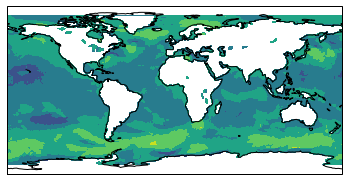

In [8]:
dataset = Dataset("/home/splash/cmems_data/ew/cmems_2020_3_26_ew.nc")
eastward_wind = dataset.variables['eastward_wind'][0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

#How CartoPy handles the problem
#CartoPy has provided documentation about transformation here: https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html
#And about Projections here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html#cartopy.crs.PlateCarree

t = time.process_time() #Starting Timer

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, eastward_wind, 4, transform=ccrs.PlateCarree())

elapsed_time = time.process_time() - t #Ending Timer
print(elapsed_time) #Printing Time

#Plotting
#ax.set_global()
#ax.coastlines()
#plt.show()